In [66]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style()
import pickle

import pandas_profiling
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() 

from sklearn.model_selection import TimeSeriesSplit

DATA_PATH = '/home/users/ucadatalab_group/davidgg/SHARED/SOLAR/data'
# We load the final df, normalized with clearsky, 16 sensors
with open(os.path.join(DATA_PATH,'oahu_min_final.pkl'),'rb') as file:
    df = pickle.load(file)

In [2]:
sys.path.insert(0,'/'.join(os.getcwd().split('/')[:-1]+['src']))
from utils.df_to_roll import df_to_roll
from utils.df_to_roll import to_array_cov1d,to_array_cov2d

In [3]:
# We load the info of the sensors to extract the longitude information
info = pd.read_csv(os.path.join(DATA_PATH,'info.csv'))

info.Location = info.Location.apply(lambda x: (x[:2] + x[-2:]).replace('_', ''))
info.index = info.Location
# Sorted longitudes
longs = info['Longitude'].sort_values(ascending=False)
# There is no AP3 in this book
longs.drop('AP3',inplace=True)
# Sort df sensors by longitude
df = df[longs.index]

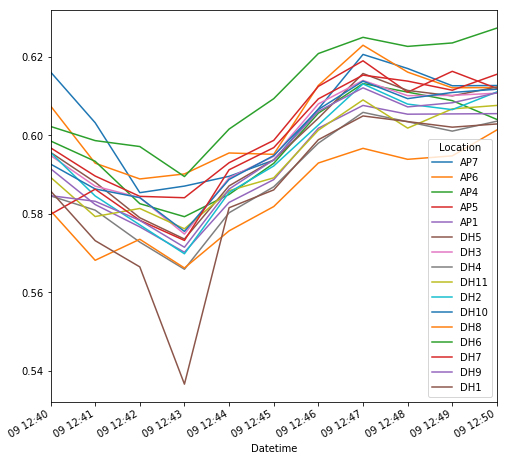

In [14]:
df.loc['2011-10-09 12:40':'2011-10-09 12:50'].plot(figsize=(8,8))

In [15]:
width= 11
step = 1
df_roll = df_to_roll(df,width=width,step=step)

# Some useful variables
longs_np = longs.index.to_numpy()
n_sensors = len(longs_np)
print('Number of sensors considered:',n_sensors)
times = df_roll.columns.levels[0].tolist()
chosen_times = times[1:width:step]
print('Chosen times slices as features:',chosen_times)
print('Number of time slices considered:',len(chosen_times))

# Split train-test, approximately 12 and 4 months respectively
df_train, df_test = df_roll[:'2011-07-31'], df_roll['2011-08-01':]

Number of sensors considered: 16
Chosen times slices as features: ['t-1', 't-10', 't-2', 't-3', 't-4', 't-5', 't-6', 't-7', 't-8', 't-9']
Number of time slices considered: 10


# Train Model

In [16]:
import tensorflow as tf
tf.test.is_gpu_available()

True

In [17]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape, Add, Multiply, Subtract, Dropout
from keras.layers import Conv2D, MaxPooling2D, LocallyConnected1D, Conv1D, UpSampling1D, MaxPooling1D, Dot, Concatenate
from keras.layers import LocallyConnected2D, Conv2D
from keras import backend as K
from clr import CyclicLR
from keras.layers import Layer, Conv2D, MaxPool2D, Flatten, Dense
from keras.initializers import Ones, Zeros

Using TensorFlow backend.


## Hyperparameters

In [73]:
# LEARNING RATE
# lr = 0.00001
# max_lr=0.02
# batch_size = 1 << 8
# iters = int(len(df_train)/batch_size)
# c2 = CyclicLR(step_size=iters, base_lr=lr,max_lr=max_lr)
# TRAIN
# lr = 0.0005
# max_lr=0.018
lr = 0.0001
max_lr=0.002
batch_size = 1 << 12   # as big as possible so we can explore many models
iters = int(len(df_train)/batch_size)
# epochs = 1 << 5
epochs = 1 << 10
opt = keras.optimizers.Adam(lr=lr)
# We add a callback to log metrics and another one to schedule the learning rate
#see clr.py in this same folder
from clr import CyclicLR
c1 = keras.callbacks.BaseLogger(stateful_metrics=None)
c2 = CyclicLR(step_size=iters*8, base_lr=lr,max_lr=max_lr, mode='exp_range', gamma=0.9999)
c3 = keras.callbacks.History()
c4 = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, 
                                   patience=20, verbose=0, mode='min', 
                                   restore_best_weights=False)
c5 = keras.callbacks.ReduceLROnPlateau(verbose=1,factor=0.5,min_lr=0.1**6, mode='min')
c6 = keras.callbacks.TensorBoard(log_dir='./logs/exp_range', histogram_freq=0, batch_size=batch_size, 
                                 write_graph=False, write_grads=False, write_images=False,
                                 embeddings_freq=0, embeddings_layer_names=None, 
                                 embeddings_metadata=None,embeddings_data=None, 
                                 update_freq='epoch')
callbacks = [c2,c5,c6]

In [74]:
def set_lr(df_roll_train,chosen_times, to_array , make_model ,k_folds_val = 5,epochs = 1,verbose = 0):
    # Preprocessing
    X_tr, y_tr = to_array(df_roll_train,chosen_times, reverse_times = True)
    time_slices = len(chosen_times)
    n_sensors = y_tr.shape[1]
    
#     mean_mae_val_list = np.zeros(k_folds_val)
    mae_val_list = np.zeros((k_folds_val,n_sensors))
    # Validation using TS split (just to obtain different MAE estimations, no hyperoptimization for the moment)
#     for i,(tr_idx, va_idx) in enumerate(TimeSeriesSplit(n_splits=k_folds_val).split(X_tr)):
    model = make_model(n_sensors=n_sensors,time_slices=time_slices)
    model.compile(optimizer = opt, loss='mean_absolute_error')

    model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, shuffle=False,
              callbacks=callbacks, verbose=verbose)
    h = c2.history
    lr_ = h['lr']
    acc_ = h['loss']
#         plt.scatter(lr_,acc_)
    sns.scatterplot(lr_,acc_)
#         plt.xlim(0,10*max_lr)
#         plt.xscale('log')
    plt.show()
    return model, mae_val_list

In [75]:
def train_and_validate(df_roll_train,chosen_times, to_array , make_model ,k_folds_val = 5,epochs = 32,verbose = 0):
    # Preprocessing
    X_tr, y_tr = to_array(df_roll_train,chosen_times, reverse_times = True)
    time_slices = len(chosen_times)
    n_sensors = y_tr.shape[1]
    

    mae_val_list = np.zeros((k_folds_val,n_sensors))
    # Validation using TS split (just to obtain different MAE estimations, no hyperoptimization for the moment)
    for i,(tr_idx, va_idx) in enumerate(TimeSeriesSplit(n_splits=k_folds_val).split(X_tr)):
        model = make_model(n_sensors=n_sensors,time_slices=time_slices)
        model.compile(optimizer = opt, loss='mean_absolute_error')
        
        model.fit(X_tr[tr_idx], y_tr[tr_idx], batch_size=batch_size, shuffle=False,
                  epochs=epochs, validation_data=
              (X_tr[va_idx],y_tr[va_idx]), callbacks=callbacks, verbose=verbose)
        mae_val_list[i] = np.mean(np.abs(model.predict(X_tr[va_idx])-y_tr[va_idx]),axis=0)
        if verbose>0:
            print('MAE_val ', mae_val_list[i].mean() ) 

    return model, mae_val_list

In [76]:
def print_mae_sensors(mae_val_list,longs_np, scale = 1):
    """
    mae_val_list : (k_folds_val, n_sensors)
    longs_np : (n_sensors)
    """
    mae_val_list = scale*mae_val_list
    print('====MAE VALIDATION=====')
    print('* MEAN: {:0.3f} (+/- {:0.3f})'.format(mae_val_list.mean(), mae_val_list.std()),
      '/ List: [',', '.join(['{:6.3f}'.format(mae) for mae in mae_val_list.mean(axis=1)]),']')
    print('====DISAGGREGATED======')
    for sensor,mae_list in zip(longs_np,mae_val_list.T):
        print("* {:4}: {:0.3f} (+/- {:0.3f})".format(sensor, mae_list.mean(), mae_list.std()),'/ List: [',', '.join(['{:6.3f}'.format(mae) for mae in mae_list]),']') 

## Conv2D Clearsky

====MAE VALIDATION=====
* MEAN: 0.083 (+/- 0.031) / List: [  0.113,  0.075,  0.037,  0.076,  0.116 ]

====DISAGGREGATED======
* AP7 : 0.093 (+/- 0.036) / List: [  0.130,  0.084,  0.037,  0.078,  0.135 ]
* AP6 : 0.092 (+/- 0.037) / List: [  0.129,  0.083,  0.035,  0.075,  0.136 ]
* AP4 : 0.087 (+/- 0.033) / List: [  0.118,  0.076,  0.036,  0.075,  0.129 ]
* AP5 : 0.077 (+/- 0.026) / List: [  0.102,  0.066,  0.035,  0.076,  0.108 ]
* AP1 : 0.076 (+/- 0.023) / List: [  0.099,  0.071,  0.037,  0.076,  0.098 ]
* DH5 : 0.091 (+/- 0.038) / List: [  0.135,  0.077,  0.036,  0.076,  0.134 ]
* DH3 : 0.083 (+/- 0.025) / List: [  0.108,  0.088,  0.037,  0.079,  0.102 ]
* DH4 : 0.079 (+/- 0.024) / List: [  0.107,  0.075,  0.037,  0.075,  0.099 ]
* DH11: 0.082 (+/- 0.032) / List: [  0.094,  0.067,  0.040,  0.074,  0.135 ]
* DH2 : 0.083 (+/- 0.029) / List: [  0.115,  0.081,  0.035,  0.075,  0.111 ]
* DH10: 0.082 (+/- 0.033) / List: [  0.135,  0.069,  0.035,  0.076,  0.096 ]
* DH8 : 0.082 (+/- 0.034) / List: [  0.100,  0.066,  0.035,  0.076,  0.135 ]
* DH6 : 0.076 (+/- 0.019) / List: [  0.096,  0.064,  0.048,  0.077,  0.096 ]
* DH7 : 0.083 (+/- 0.028) / List: [  0.116,  0.077,  0.036,  0.076,  0.108 ]
* DH9 : 0.078 (+/- 0.024) / List: [  0.103,  0.070,  0.037,  0.080,  0.101 ]
* DH1 : 0.088 (+/- 0.034) / List: [  0.120,  0.078,  0.036,  0.075,  0.129 ]

In [71]:
def make_model_all_conv2d( n_sensors=17, time_slices = 1):
    ''' Returns a model using all the sensors to predict index_sensor 
    Input shape : (items, time_slice, sensor, 1), 'channels_last'
    '''
    xin = Input(shape=(n_sensors,time_slices,1), name='main_input')
    '''
    When using this layer as the first layer in a model, provide an input_shape argument 
    (tuple of integers or None, does not include the batch axis), e.g. input_shape=(10, 128) 
    for time series sequences of 10 time steps with 128 features per step in data_format="channels_last", 
    or (None, 128) for variable-length sequences with 128 features per step.
    '''
    # The convolution is across time, and each sensor is a channel
    x = LocallyConnected2D(n_sensors, 3, data_format = 'channels_last', padding='valid',activation='relu', name='LocCon1')(xin)
#     x = keras.layers.AveragePooling2D((2,2))(x)
    x = LocallyConnected2D(int(n_sensors/2), 3, data_format = 'channels_last', padding='valid',activation='relu', name='LocCon2')(x)
    x = Conv2D(n_sensors, 3, data_format = 'channels_last', padding='valid', name='Con1')(x)
    xl = Dropout(0.2,name='Dropout')(Flatten(name='Flatten1')(x))
    
    # First features
    xo = Dense(2*n_sensors, name='CFeatDense1',activation='relu')(xl)
    xo = Dense(n_sensors, name='CFeatFDense2',activation='relu')(xo)
    # Shape (batch_size)*(n_sensors,1)
    xo_reshaped = Reshape((n_sensors,1), name = 'CFeatFReshape')(xo)
    
    # sort of residual connection, we only take the last timestamp of the given sensor x[:,-1:,index_sensor]
    xin_0 = Activation('relu',name='RFeatRelu')(xin)
    # Shape (batch_size)*(n_sensors,1)
    xin_1 = Lambda(lambda x : x[:,:,-1:,0],name='RFeatLambda')(xin_0)
    
    # Weights
    # use date info here?
    xinf = Flatten()(xin)
    s  = Dense(5*n_sensors, activation='tanh',name='WFeatDense1')(xinf)
    s  = Dense(4*n_sensors, activation='tanh',name='WFeatDense2')(s)
    s  = Dense(3*n_sensors, activation='tanh',name='WFeatDense3')(s)
    s = Dense(2*n_sensors, name='WFeatDense4',activation='sigmoid')(s)
    weights = Reshape((n_sensors,2),name='WFeatReshape')(s)
    # Softmax over the second axis, this is, we 2 values that sum up to one for each sensor.
#     s = Lambda(lambda x : keras.activations.softmax(x,axis=2), name = 'WFeatSoftmax')(s)
#     s = Activation(keras.activations.softmax(x,axis=1))(s)
    
    # Check dimensions here, and the axes for Concatenate and Dot, we want n_sensors outputs
    # Shape (batch_size)*(n_sensors,2)
    # Notation alert! The axis here is counting the batch_size one.
    x_concat = Concatenate(axis=2, name='ConcatCandR')([xo_reshaped,xin_1])
    
    x_weighted = keras.layers.Multiply(name='Multiply')([x_concat,weights])
    x_sum = Lambda(lambda x: K.sum(x, axis=2))(x_weighted)
#     xo_m = Dot(axes=2, name='WeightedMean')([x_concat, weights])
    # We need to take the diagonal
#     def diagonal(tensor):
#         out = []
#         for i in range(n_sensors):
#             out.append(tensor[:,i:i+1,i])
#         return out
#     xo_m = Lambda(diagonal, name='Diagonal')(xo_m)
#     x_sum = Concatenate(axis=1, name='Tensorize')(xo_m)
    
    # We want positive results
    x_final = Activation('relu', name='FinalRelu')(x_sum)
    model = Model(inputs=[xin], outputs=[x_final])
    return model

In [ ]:
# model = make_model_all_conv2d(n_sensors,len(chosen_times))
# model.summary()

Epoch 1/1


/home/data/ucadatalab_group/envs/solar/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250390). Check your callbacks.
  % delta_t_median)


 - 40s - loss: 0.1044


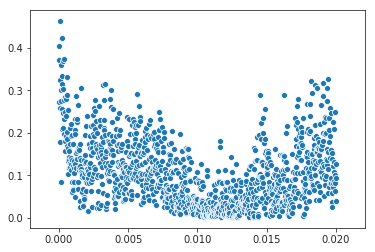

In [54]:
model, mae_val_list = set_lr(df_train,chosen_times,
                                         to_array_cov2d,
                                         make_model_all_conv2d,
                                         epochs=1,
                                         verbose=2)

In [33]:
lr

1e-06

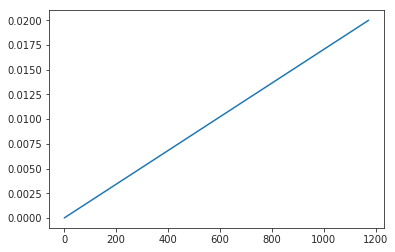

In [56]:
sns.lineplot(c2.history['iterations'],c2.history['lr'])

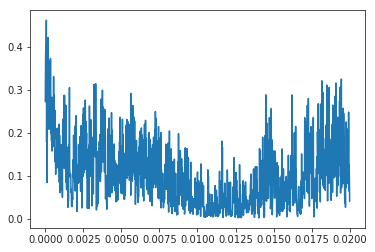

In [60]:
sns.set_style('ticks')
sns.lineplot(c2.history['lr'],c2.history['loss'])
# plt.xscale('log')

In [ ]:
model, mae_val_list = train_and_validate(df_train,chosen_times,
                                         to_array_cov2d,
                                         make_model_all_conv2d,
                                         epochs=epochs,
                                         verbose=2)
print_mae_sensors(mae_val_list,longs_np)

Train on 50015 samples, validate on 50014 samples
Epoch 1/1024


/home/data/ucadatalab_group/envs/solar/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.379929). Check your callbacks.
  % delta_t_median)


 - 8s - loss: 0.3335 - val_loss: 0.3187
Epoch 2/1024
 - 1s - loss: 0.2775 - val_loss: 0.2499
Epoch 3/1024
 - 1s - loss: 0.2035 - val_loss: 0.1736
Epoch 4/1024
 - 1s - loss: 0.1572 - val_loss: 0.1556
Epoch 5/1024
 - 1s - loss: 0.1443 - val_loss: 0.1464
Epoch 6/1024
 - 1s - loss: 0.1384 - val_loss: 0.1423
Epoch 7/1024
 - 1s - loss: 0.1352 - val_loss: 0.1398
Epoch 8/1024
 - 1s - loss: 0.1331 - val_loss: 0.1379
Epoch 9/1024
 - 1s - loss: 0.1315 - val_loss: 0.1364
Epoch 10/1024
 - 1s - loss: 0.1303 - val_loss: 0.1351
Epoch 11/1024
 - 1s - loss: 0.1292 - val_loss: 0.1338
Epoch 12/1024
 - 1s - loss: 0.1282 - val_loss: 0.1325
Epoch 13/1024
 - 1s - loss: 0.1272 - val_loss: 0.1314
Epoch 14/1024
 - 1s - loss: 0.1262 - val_loss: 0.1313
Epoch 15/1024
 - 1s - loss: 0.1253 - val_loss: 0.1292
Epoch 16/1024
 - 1s - loss: 0.1243 - val_loss: 0.1284
Epoch 17/1024
 - 1s - loss: 0.1235 - val_loss: 0.1274
Epoch 18/1024
 - 1s - loss: 0.1227 - val_loss: 0.1264
Epoch 19/1024
 - 1s - loss: 0.1219 - val_loss: 0.1

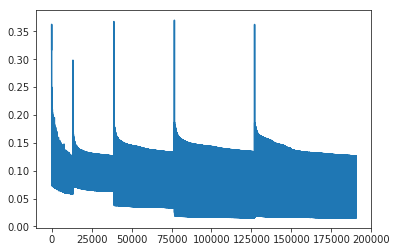

In [81]:
sns.lineplot(c2.history['iterations'],c2.history['loss'])

In [78]:
print_mae_sensors(mae_val_list,longs_np)

====MAE VALIDATION=====
* MEAN: 0.075 (+/- 0.029) / List: [  0.109,  0.069,  0.033,  0.065,  0.102 ]
====DISAGGREGATED======
* AP7 : 0.092 (+/- 0.036) / List: [  0.132,  0.084,  0.036,  0.076,  0.132 ]
* AP6 : 0.090 (+/- 0.037) / List: [  0.130,  0.081,  0.034,  0.071,  0.133 ]
* AP4 : 0.083 (+/- 0.033) / List: [  0.118,  0.073,  0.034,  0.068,  0.121 ]
* AP5 : 0.072 (+/- 0.025) / List: [  0.099,  0.062,  0.034,  0.062,  0.101 ]
* AP1 : 0.070 (+/- 0.025) / List: [  0.100,  0.066,  0.031,  0.060,  0.092 ]
* DH5 : 0.073 (+/- 0.026) / List: [  0.105,  0.071,  0.032,  0.061,  0.094 ]
* DH3 : 0.076 (+/- 0.025) / List: [  0.107,  0.068,  0.036,  0.073,  0.098 ]
* DH4 : 0.071 (+/- 0.026) / List: [  0.104,  0.067,  0.031,  0.061,  0.093 ]
* DH11: 0.071 (+/- 0.028) / List: [  0.113,  0.062,  0.032,  0.059,  0.088 ]
* DH2 : 0.078 (+/- 0.029) / List: [  0.114,  0.075,  0.033,  0.065,  0.101 ]
* DH10: 0.068 (+/- 0.024) / List: [  0.098,  0.062,  0.031,  0.059,  0.090 ]
* DH8 : 0.067 (+/- 0.022) / 

In [139]:
print_mae_sensors(mae_val_list,longs_np)

====MAE VALIDATION=====
* MEAN: 0.083 (+/- 0.031) / List: [  0.113,  0.075,  0.037,  0.076,  0.116 ]
====DISAGGREGATED======
* AP7 : 0.093 (+/- 0.036) / List: [  0.130,  0.084,  0.037,  0.078,  0.135 ]
* AP6 : 0.092 (+/- 0.037) / List: [  0.129,  0.083,  0.035,  0.075,  0.136 ]
* AP4 : 0.087 (+/- 0.033) / List: [  0.118,  0.076,  0.036,  0.075,  0.129 ]
* AP5 : 0.077 (+/- 0.026) / List: [  0.102,  0.066,  0.035,  0.076,  0.108 ]
* AP1 : 0.076 (+/- 0.023) / List: [  0.099,  0.071,  0.037,  0.076,  0.098 ]
* DH5 : 0.091 (+/- 0.038) / List: [  0.135,  0.077,  0.036,  0.076,  0.134 ]
* DH3 : 0.083 (+/- 0.025) / List: [  0.108,  0.088,  0.037,  0.079,  0.102 ]
* DH4 : 0.079 (+/- 0.024) / List: [  0.107,  0.075,  0.037,  0.075,  0.099 ]
* DH11: 0.082 (+/- 0.032) / List: [  0.094,  0.067,  0.040,  0.074,  0.135 ]
* DH2 : 0.083 (+/- 0.029) / List: [  0.115,  0.081,  0.035,  0.075,  0.111 ]
* DH10: 0.082 (+/- 0.033) / List: [  0.135,  0.069,  0.035,  0.076,  0.096 ]
* DH8 : 0.082 (+/- 0.034) / 